In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Colormap 

np.random.seed(0)

# Quick overview

In [2]:
forward_rate =  pd.read_csv('data/hjm_data.csv').set_index('time') / 100 # Convert interest rates to %
forward_rate.head()

,1/12,1/2,1,1.5,2,2.5,3,3.5,4,4.5,...,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25
time,,,,,,,,,,,,,,,,,,,,,
1,0.057734,0.064382,0.067142,0.066512,0.064991,0.063255,0.061534,0.059925,0.058444,0.057058,...,0.034194,0.034772,0.035371,0.035985,0.036612,0.037252,0.037902,0.038562,0.039231,0.039908
2,0.057680,0.064506,0.067502,0.066842,0.065423,0.063852,0.062301,0.060846,0.059490,0.058198,...,0.033790,0.034437,0.035108,0.035798,0.036504,0.037224,0.037959,0.038705,0.039461,0.040227
3,0.057758,0.064410,0.067354,0.066845,0.065577,0.064109,0.062611,0.061164,0.059782,0.058438,...,0.032706,0.033294,0.033907,0.034539,0.035188,0.035853,0.036533,0.037224,0.037927,0.038639
4,0.057430,0.064103,0.066942,0.066215,0.064904,0.063462,0.062006,0.060601,0.059252,0.057933,...,0.031325,0.031891,0.032486,0.033106,0.033748,0.034409,0.035088,0.035784,0.036493,0.037214
5,0.057412,0.063978,0.066358,0.065502,0.064168,0.062722,0.061262,0.059849,0.058488,0.057157,...,0.030119,0.030667,0.031250,0.031862,0.032499,0.033161,0.033844,0.034546,0.035264,0.035997


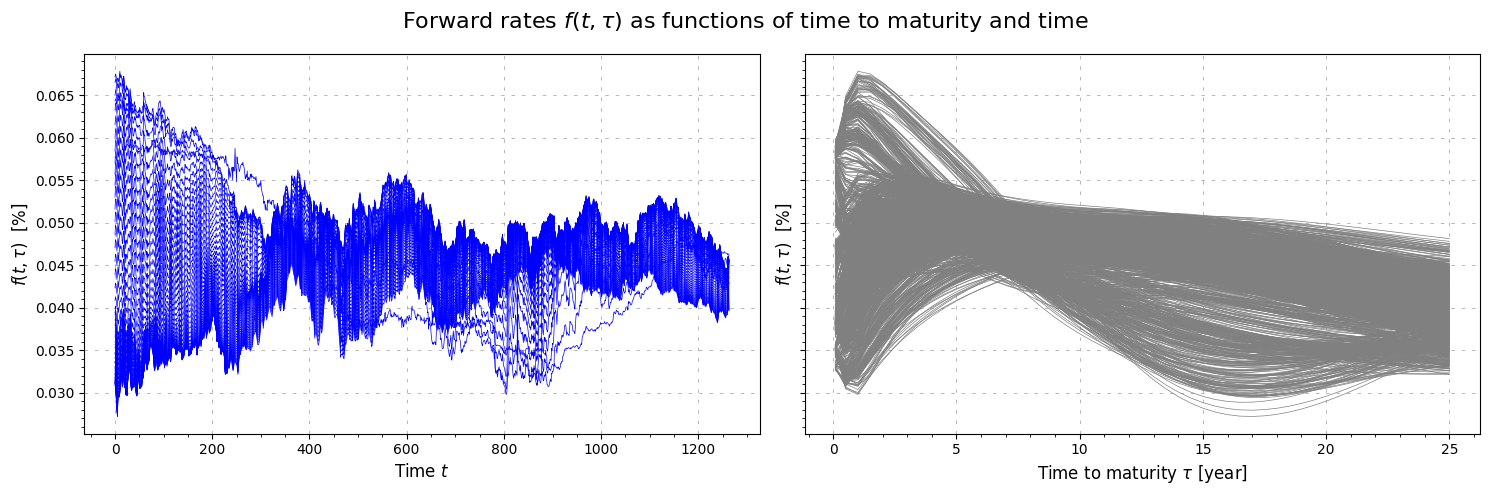

In [3]:
hist_timeline = list(forward_rate.index)
tenors = [eval(x) for x in forward_rate.columns]
hist_rates = forward_rate.to_numpy()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1.plot(hist_rates, color='blue', linewidth=0.5)
ax1.set_ylabel(r'$f(t,\tau)$  [$\%$]', fontsize=12)
ax1.set_xlabel(r'Time $t$', fontsize=12)
ax1.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
ax1.minorticks_on()
ax1.grid(which="minor", visible=False)

ax2.plot(tenors, hist_rates.transpose(), color='gray', linewidth=0.5)
ax2.set_ylabel(r'$f(t,\tau)$  [$\%$]', fontsize=12)
ax2.set_xlabel(r'Time to maturity $\tau$ [year]', fontsize=12)
ax2.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
ax2.minorticks_on()
ax2.grid(which="minor", visible=False)


fig.suptitle(r'Forward rates $f(t,\tau)$ as functions of time to maturity and time', fontsize=16)
plt.tight_layout()
plt.savefig(fname='plots/forward-rates.pdf')
plt.show()

# Differentiate historical rates

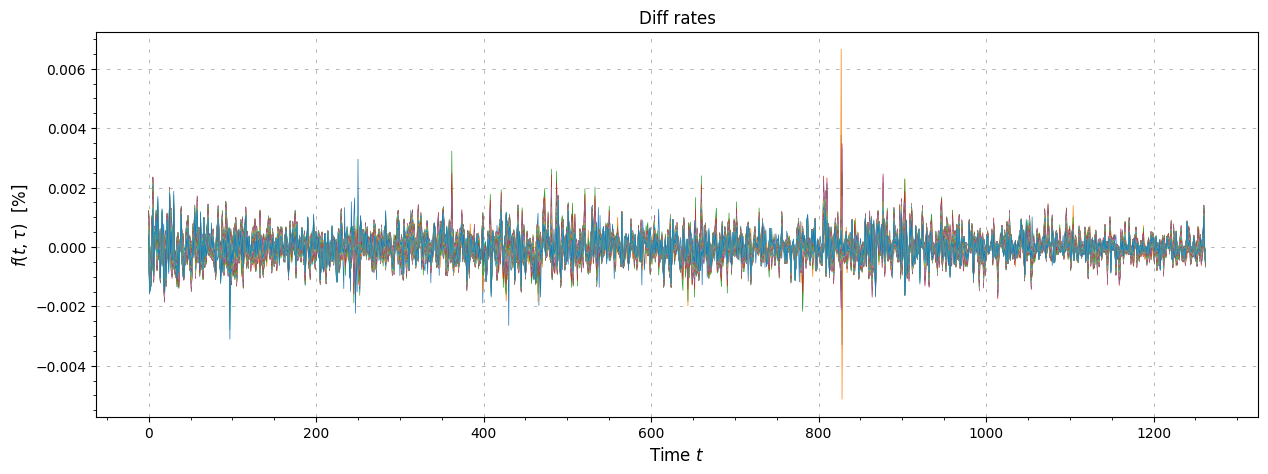

In [4]:
diff_rates = np.diff(hist_rates, axis=0)

fig, ax = plt.subplots(1, figsize=(15,5))

ax.plot(diff_rates, linewidth=0.5)
ax.set_ylabel(r'$f(t,\tau)$  [$\%$]', fontsize=12)
ax.set_xlabel(r'Time $t$', fontsize=12)
ax.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
ax.minorticks_on()
ax.grid(which="minor", visible=False)
plt.title('Diff rates')
plt.savefig(fname='plots/diff-rates.pdf')
plt.show()

# Principal component analysis

Extract principal components from the $df(t,\tau)$

In [5]:
# Calculate covariance matrix
sigma = np.cov(diff_rates.transpose())

Source data are daily rates, therefore annualize covariance matrix (252 financial days). Then compute eigenvalues and eigenvectors

In [6]:
sigma = sigma * 252
eigval, eigvec = np.linalg.eig(sigma)
eigvec = np.matrix(eigvec)
print(eigval)

[2.02884026e-03 4.62889282e-04 1.63677691e-04 8.47948767e-05
 5.10134525e-05 3.26491422e-05 1.53862297e-05 3.90765854e-06
 1.45385608e-06 3.99451236e-07 7.74123147e-08 2.25094244e-08
 6.81015644e-09 2.04941493e-09 8.30654947e-10 3.18422245e-10
 1.69855176e-10 1.20686709e-10 8.18818675e-11 4.65678731e-11
 2.41691330e-11 1.26818337e-11 7.83625735e-12 4.07031445e-12
 2.61695757e-12 1.78999756e-12 1.07235511e-12 6.26514631e-13
 3.36669763e-13 2.89485592e-13 2.09893594e-13 2.02355379e-13
 1.20792326e-13 9.80002681e-14 7.30539108e-14 5.84913877e-14
 5.01860718e-14 4.50412066e-14 4.25136155e-14 3.00503786e-14
 1.99691814e-14 1.44931169e-14 8.67085372e-15 6.67525091e-15
 5.37129004e-15 4.23435563e-15 2.52344995e-15 1.26741475e-15
 4.34926875e-17 1.87394604e-16 2.51628579e-16]


Determine principal components, Select eigen vectors with highest eigenvalues. Link between tenors and eigenvectors is not guaranteed.

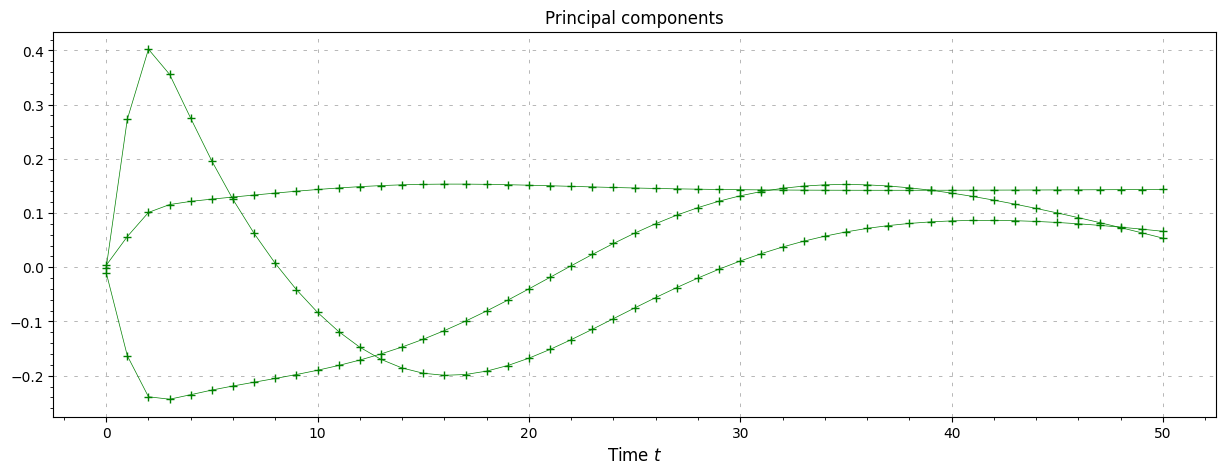

In [7]:
factors=3
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # Principal eigenvectors
princ_eigval = np.array([eigval[i] for i in index_eigvec])   # Principal eigenvalues
princ_comp = np.hstack([eigvec[:,i] for i in index_eigvec])  # Principal components

fig, ax = plt.subplots(1, figsize=(15,5),)

ax.plot(princ_comp, marker='+', color='green', linewidth=0.5)
ax.set_xlabel(r'Time $t$', fontsize=12)
ax.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
ax.minorticks_on()
ax.grid(which="minor", visible=False)
plt.title("Principal components")
plt.savefig(fname='plots/discretized-volatilities.pdf')
plt.show()

Calculate discretized volatility function from principal components

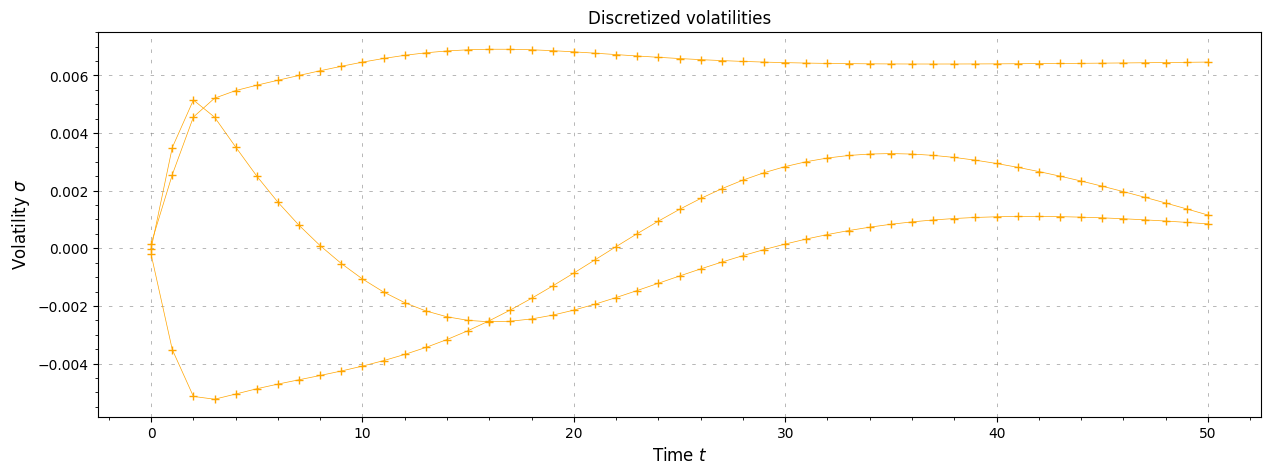

In [8]:
sqrt_eigval = np.matrix(princ_eigval ** .5)
tmp_m = np.vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = np.multiply(tmp_m, princ_comp) # multiply matrice element-wise


fig, ax = plt.subplots(1, figsize=(15,5),)

ax.plot(vols, marker='+', color='orange', linewidth=0.5)
ax.set_ylabel(r'Volatility $\sigma$', fontsize=12)
ax.set_xlabel(r'Time $t$', fontsize=12)
ax.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
ax.minorticks_on()
ax.grid(which="minor", visible=False)
plt.title("Discretized volatilities")
plt.savefig(fname='plots/discretized-volatilities.pdf')
plt.show()

# Volatility Fitting

We need to fit discretized volatility functions from the previous step using cubic interpolators. The reason is that these interpolators will be later integrated numerically in order to calculate risk-neutral drift. Fitting is done using cubic spline

In [9]:
def get_matrix_column(mat, i):
    return np.array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params:np.ndarray):
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = np.array([x**i for i in reversed(range(n))])
        return sum(np.multiply(X, C))

We will approximate the first principal component with interpolator with 0 degree (straight line). This approximates well parallel movements of interest rates.

In [10]:
fitted_vols = []

2nd and 3rd principal component will be approximated using cubic interpolator with degree 3.

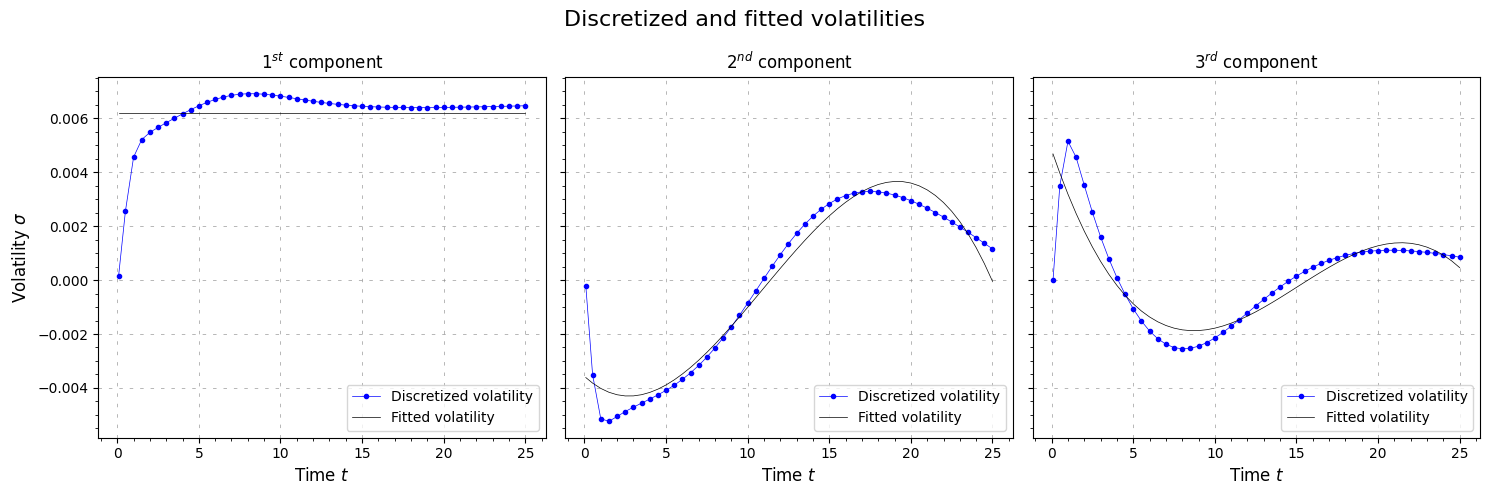

In [11]:
def fit_volatility(i, degree, title, ax):
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(np.polyfit(tenors, vol, degree))    
    fitted_vols.append(fitted_vol)

    ax.plot(tenors, vol, marker='.', label='Discretized volatility', color='blue', linewidth=0.5)
    ax.plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility', color='black', linewidth=0.5)

    ax.set_title(title)
    ax.grid(which="minor", visible=False)
    ax.grid(visible=True,which="major",linestyle="--",dashes=(5, 10),color="gray",linewidth=0.5,alpha=0.8)
    ax.minorticks_on()
    ax.set_xlabel(r'Time $t$', fontsize=12)
    ax.legend(loc='lower right')



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharey=True)
plt.title("Discretized and fitted volatilities")
ax1.set_ylabel(r'Volatility $\sigma$', fontsize=12)
fit_volatility(0, 0, r'$1^{st}$ component', ax1)
fit_volatility(1, 3, r'$2^{nd}$ component', ax2)
fit_volatility(2, 3, r'$3^{rd}$ component', ax3)

fig.suptitle(r'Discretized and fitted volatilities', fontsize=16)
plt.tight_layout()
plt.savefig(fname='plots/discretized-and-fitted-volatilities.pdf')
plt.show()

# Monte Carlo Simulation